In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from imblearn.pipeline import Pipeline as imbPipeline

%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
df_values = pd.read_csv('Data/Nepal_Earthquake_train_values.csv', index_col='building_id')
df_labels = pd.read_csv('Data/Nepal_Earthquake_train_labels.csv', index_col='building_id')

### Merge the values dataframe with the labels dataframe

In [3]:
df = df_values.join(df_labels)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 260601 entries, 802906 to 747594
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   geo_level_1_id                          260601 non-null  int64 
 1   geo_level_2_id                          260601 non-null  int64 
 2   geo_level_3_id                          260601 non-null  int64 
 3   count_floors_pre_eq                     260601 non-null  int64 
 4   age                                     260601 non-null  int64 
 5   area_percentage                         260601 non-null  int64 
 6   height_percentage                       260601 non-null  int64 
 7   land_surface_condition                  260601 non-null  object
 8   foundation_type                         260601 non-null  object
 9   roof_type                               260601 non-null  object
 10  ground_floor_type                       260601 non-

### Target Distribution

In [5]:
df['damage_label'] = df.damage_grade.map(
    {1:'Low Damage', 2:'Medium Damage', 3:'Complete Destruction'})

In [6]:
df.damage_label.value_counts(normalize=True)

Medium Damage           0.568912
Complete Destruction    0.334680
Low Damage              0.096408
Name: damage_label, dtype: float64

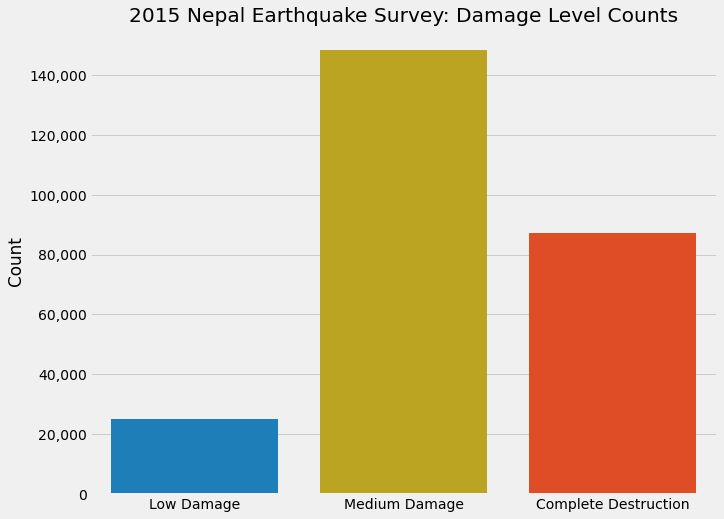

In [7]:
palette = {'Low Damage' : 'xkcd:cerulean', 
           'Medium Damage': 'xkcd:dark yellow',
           'Complete Destruction': 'xkcd:red orange'}
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.countplot(x='damage_label', data=df, palette=palette, 
                   order=['Low Damage', 'Medium Damage', 'Complete Destruction'])
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('')
ax.set_ylabel('Count')
ax.set_title('2015 Nepal Earthquake Survey: Damage Level Counts');

### Create column categories

In [8]:
binary_cols = []
for col in df.columns:
    if col.startswith('has'):
        binary_cols.append(col)

cat_cols = list(df.select_dtypes(include='object').columns)
cat_cols.remove('damage_label')

integer_cols = ['count_floors_pre_eq', 'age', 'area_percentage', 'height_percentage', 'count_families']

geo_cols = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

all_cols = geo_cols + cat_cols + integer_cols + binary_cols

In [9]:
len(all_cols)

38

### Categorical Columns

In [10]:
n_unique = 0
for col in cat_cols:
    n_unique += df[col].nunique()
    print(f"There are {df[col].nunique()} unique values in the feature '{col}'.")
    print(f"The values are {df[col].unique()}")
    print("--------------------------------")
print(f'There are {n_unique} total categorical values in the categorical columns.')

There are 3 unique values in the feature 'land_surface_condition'.
The values are ['t' 'o' 'n']
--------------------------------
There are 5 unique values in the feature 'foundation_type'.
The values are ['r' 'w' 'i' 'u' 'h']
--------------------------------
There are 3 unique values in the feature 'roof_type'.
The values are ['n' 'q' 'x']
--------------------------------
There are 5 unique values in the feature 'ground_floor_type'.
The values are ['f' 'x' 'v' 'z' 'm']
--------------------------------
There are 4 unique values in the feature 'other_floor_type'.
The values are ['q' 'x' 'j' 's']
--------------------------------
There are 4 unique values in the feature 'position'.
The values are ['t' 's' 'j' 'o']
--------------------------------
There are 10 unique values in the feature 'plan_configuration'.
The values are ['d' 'u' 's' 'q' 'm' 'c' 'a' 'n' 'f' 'o']
--------------------------------
There are 4 unique values in the feature 'legal_ownership_status'.
The values are ['v' 'a' 'r

### Binary Columns

<ipython-input-11-21fa6e00ad8f>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(list(mean_binary_cols.index), rotation=90)


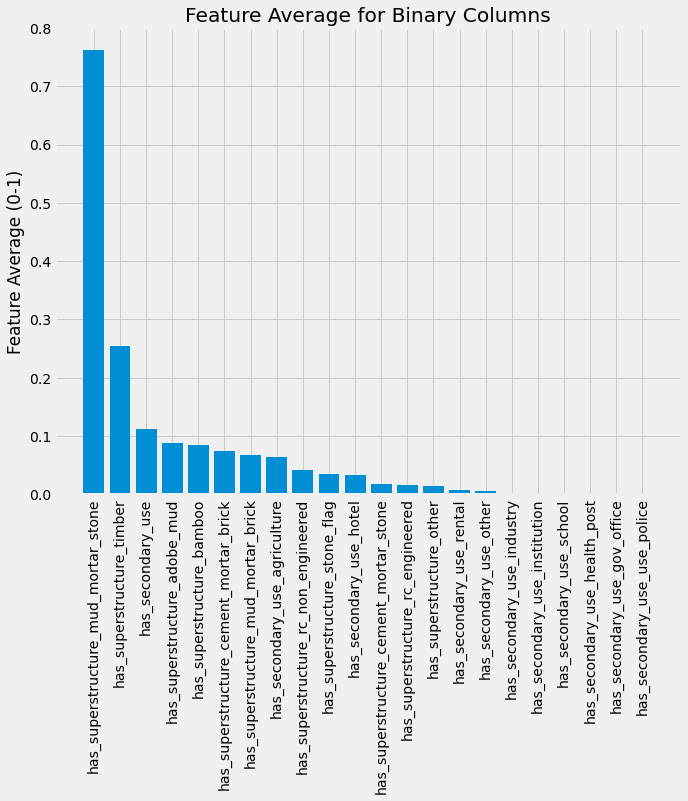

In [11]:
mean_binary_cols = df[binary_cols].mean().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(10,8))
ax.bar(mean_binary_cols.index, mean_binary_cols.values)
ax.set_xticklabels(list(mean_binary_cols.index), rotation=90)
ax.set_ylabel('Feature Average (0-1)')
ax.set_title('Feature Average for Binary Columns');

In [12]:
superstructure_cols = [col for col in binary_cols if col.startswith('has_superstructure')]

In [13]:
superstructure_cols

['has_superstructure_adobe_mud',
 'has_superstructure_mud_mortar_stone',
 'has_superstructure_stone_flag',
 'has_superstructure_cement_mortar_stone',
 'has_superstructure_mud_mortar_brick',
 'has_superstructure_cement_mortar_brick',
 'has_superstructure_timber',
 'has_superstructure_bamboo',
 'has_superstructure_rc_non_engineered',
 'has_superstructure_rc_engineered',
 'has_superstructure_other']

In [ ]:
df_superstructure = pd.DataFrame(columns=['superstructure', 'Low Damage', 'Medium Damage', 'Complete Destruction'])
count = 0
for col in superstructure_cols:
    df1 = df[(df[col] == 1) & df[df.damage_grade == 1]] 
    num_1 = len(df1)
    df2 = df[(df[col] == 1) & df[df.damage_grade == 2]] 
    num_2 = len(df2)
    df3 = df[(df[col] == 1) & df[df.damage_grade == 3]] 
    num_3 = len(df3)
    df_superstructure.loc[count, 'superstructure'] = col
    df_superstructure.loc[count, 'Low Damage'] = num_1 / (num_1 + num_2 + num_3) * 100
    df_superstructure.loc[count, 'Medium Damage'] = num_2 / (num_1 + num_2 + num_3) * 100
    df_superstructure.loc[count, 'Complete Destruction'] = num_3 / (num_1 + num_2 + num_3) * 100
    count += 1

### Integer Columns

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for ax, col in zip(axs, integer_cols):
    sns.kdeplot(df[col], ax=ax, shade=True);

In [ ]:
df_age = pd.DataFrame(columns=['age', 'Low Damage', 'Medium Damage', 'Complete Destruction'])
count = 0
for age in range(0,105,5):
    num_1 = 0
    num_2 = 0
    num_3 = 0
    df1 = df[(df.age == age) & (df.damage_grade == 1)]
    num_1 += len(df1)
    df2 = df[(df.age == age) & (df.damage_grade == 2)]
    num_2 += len(df2)
    df3 = df[(df.age == age) & (df.damage_grade == 3)]
    num_3 += len(df3)
    df_age.loc[count, 'age'] = age
    df_age.loc[count, 'Low Damage'] = num_1 / (num_1 + num_2 + num_3) * 100
    df_age.loc[count, 'Medium Damage'] = num_2 / (num_1 + num_2 + num_3) * 100
    df_age.loc[count, 'Complete Destruction'] = num_3 / (num_1 + num_2 + num_3) * 100
    count += 1

In [ ]:
melt_df_age = df_age.melt(id_vars='age')
melt_df_age

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x='age', y='value', hue='variable', data=melt_df_age, palette=palette, ax=ax)
ax.set_ylabel('Percent')
ax.set_xlabel('Age (years)')
ax.set_title('Percent Level of Damage by Building Age')
ax.legend(title='');

In [ ]:
df_floors = pd.DataFrame(columns=['floors', 'Low Damage', 'Medium Damage', 'Complete Destruction'])
count = 0
for floor in range(1,8,1):
    num_1 = 0
    num_2 = 0
    num_3 = 0
    df1 = df[(df.count_floors_pre_eq == floor) & (df.damage_grade == 1)]
    num_1 += len(df1)
    df2 = df[(df.count_floors_pre_eq == floor) & (df.damage_grade == 2)]
    num_2 += len(df2)
    df3 = df[(df.count_floors_pre_eq == floor) & (df.damage_grade == 3)]
    num_3 += len(df3)
    df_floors.loc[count, 'floors'] = floor
    df_floors.loc[count, 'Low Damage'] = num_1 / (num_1 + num_2 + num_3) * 100
    df_floors.loc[count, 'Medium Damage'] = num_2 / (num_1 + num_2 + num_3) * 100
    df_floors.loc[count, 'Complete Destruction'] = num_3 / (num_1 + num_2 + num_3) * 100
    count += 1

In [ ]:
melt_df_floors = df_floors.melt(id_vars='floors')
melt_df_floors

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
sns.barplot(x='floors', y='value', hue='variable', data=melt_df_floors, palette=palette, ax=ax)
ax.set_ylabel('Percent')
ax.set_xlabel('Number of Floors')
ax.set_title('Percent Level of Damage by Number of Floors')
ax.legend(title='');

In [ ]:
df_log = pd.DataFrame(index=df.index)
for col in integer_cols:
    df_log[f'log_{col}'] = df[col].apply(lambda x: np.log(x+1))

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
for ax, col in zip(axs, df_log.columns):
    sns.kdeplot(df_log[col], ax=ax, shade=True);

### Geographical Columns

In [ ]:
for col in geo_cols:
    print(f'There are {df[col].nunique()} unique values in {col}.')
    print(f'The range of values is: {df[col].min()}, {df[col].max()}.')
    print('---------------------------------')

### Correlations

In [ ]:
fig, ax = plt.subplots(figsize=(4,10))
sns.heatmap(df.corr()[['damage_grade']].sort_values(by='damage_grade', ascending=False),
           vmin=-1, vmax=1, linewidths=1, linecolor='black', annot=True, cmap="gist_heat");

In [ ]:
corr_matrix_mask = np.triu(np.ones_like(df.corr(), dtype=bool))
fig, ax = plt.subplots(figsize  =(30,30))
sns.heatmap(
            df.corr(), 
            ax=ax, 
            annot=True, 
            mask= corr_matrix_mask,
            cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
);

### Train Test Split

In [ ]:
X = df.drop(['damage_grade', 'damage_label'], axis=1)
y = df.damage_grade

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [ ]:
X_train.to_csv('Data/X_train.csv')
X_test.to_csv('Data/X_test.csv')
y_train.to_csv('Data/y_train.csv')
y_test.to_csv('Data/y_test.csv')

### Random Forest without feature engineering to check feature importances

In [ ]:
dummy_X_train = pd.get_dummies(X_train)

In [ ]:
baseline_forest = RandomForestClassifier(random_state=42)
baseline_forest.fit(dummy_X_train, y_train)

In [ ]:
with open ('../Models/baseline_forest.pickle', 'wb') as f:
    pickle.dump(baseline_forest, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
f1_micro = cross_val_score(baseline_forest, dummy_X_train, y_train, scoring='f1_micro')

In [ ]:
f1_micro = f1_micro.mean()
f1_micro

In [ ]:
feat_importance = pd.DataFrame(baseline_forest.feature_importances_, 
                               columns=['Importance'], index=dummy_X.columns)
feat_importance_sorted = feat_importance.sort_values(by='Importance', ascending=True)
fig, ax = plt.subplots(figsize=(15,20))
ax.barh(feat_importance_sorted.index, feat_importance_sorted.Importance);

In [ ]:
len(feat_importance)